# Online Deterministic Annealing (ODA) for Regression

> A general-purpose learning model designed to meet the needs of applications in which computational resources are limited, and robustness and interpretability are prioritized.

> Constitutes an **online** prototype-based learning algorithm based on annealing optimization that is formulated as an recursive **gradient-free** stochastic approximation algorithm.

> Can be viewed as an interpretable and progressively growing competitive-learning neural network model.

> Christos Mavridis (<mavridis@umd.edu>)

In [1]:
%matplotlib inline
from IPython.display import HTML

# Toggle on/off the raw code
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Toggle on/off the raw code."></form>''')

## Import Modules

In [2]:
import pickle
import numpy as np

import os
import sys
sys.path.append('../OnlineDeterministicAnnealing/')

from oda import ODA 

# For Plotting Figures horizontally
import matplotlib.pyplot as plt
import io
import base64
class FlowLayout(object):
    ''' A class / object to display plots in a horizontal / flow layout below a cell '''
    def __init__(self):
        # string buffer for the HTML: initially some CSS; images to be appended
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        margin: 10px;
        border: 3px solid #888888;  
        }
        </style>
        """

    def add_plot(self, oAxes):
        ''' Saves a PNG representation of a Matplotlib Axes object '''
        Bio=io.BytesIO() # bytes buffer for the plot
        fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) # make a png of the plot in the buffer

        # encode the bytes as string using base 64 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            '</div>')

    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))

print('*** ODA Class Imported ***')

*** ODA Class Imported ***


## Load Data

Training Data Format: [[array([18.37837838])], ..., [array([0.15015015])]]
Training Labels Format: [[0.29556178], ..., [1.54698172]]



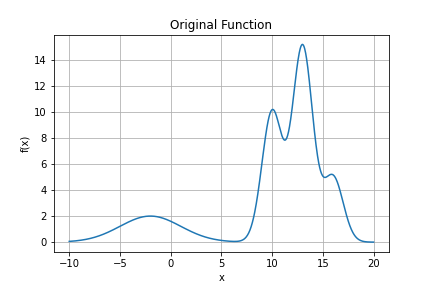

In [3]:
# Function to fit
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
def f(x):
    # return np.heaviside(x,0) * 5*np.sin(2*np.pi*0.1*x) 
    return 2 * gaussian(x,-2,3) + 10 * gaussian(x,10,1) + 15 * gaussian(x,13,1) + 5 * gaussian(x,16,1)

# Train data
xo = np.atleast_2d(np.linspace(-10, 20, 1000)).T
yo = f(xo).ravel()
shi = np.arange(len(xo))
np.random.shuffle(shi)
x = [[xo[i]] for i in shi]
y = [np.array([yo[i]]) for i in shi]
train_data=[xx for xx in x]
train_labels=[yy for yy in y]

# Test data
xoo = np.atleast_2d(np.linspace(-10, 20, 100)).T
yoo = f(xoo).ravel()
shi = np.arange(len(xoo))
np.random.shuffle(shi)
x = [[xoo[i]] for i in shi]
y = [np.array([yoo[i]]) for i in shi]
test_data=[xx for xx in x]
test_labels=[yy for yy in y]

# Resolutions
res=[0]
train_data = [[td[r] for r in res] for td in train_data]
test_data = [[td[r] for r in res] for td in test_data]
    
print(f'Training Data Format: [{train_data[0]}, ..., {train_data[-1]}]')
print(f'Training Labels Format: [{train_labels[0]}, ..., {train_labels[-1]}]')

oPlot = FlowLayout()
ax = plt.subplot(111, autoscale_on=True)
plt.plot(xo,yo)
plt.grid()
plt.title('Original Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.close()
oPlot.add_plot(ax)
oPlot.PassHtmlToCell()

## Cost Function (Bregman Divergence)

In [4]:
# Bregman Divergence: Values in {'phi_Eucl', 'phi_KL'} (Squared Euclidean distance, KL divergence)
Bregman_phi = ['phi_Eucl'] 

## Termination Criteria

In [5]:
# Minimum Termperature 
Tmin = [1e-3]

# Limit in node's children. After that stop growing
Kmax = [75]
# Limit in the number of convergent representations. (Developer Mode) 
timeline_limit = 1e3
# Desired training error. 
error_threshold = [0.0]
# Stop when reached 'error_threshold_count' times
error_threshold_count = [2]

# ODA vs Soft-Clustering vs LVQ
# Values in {0,1,2,3}
# 0:ODA update
# 1:ODA until Kmax. Then switch to 2:soft clustering with no perturbation/merging 
# 2:soft clustering with no perturbation/merging 
# 3: LVQ update (hard-clustering) with no perturbation/merging
lvq=[0]

## Comments on Termination Criteria

> These are predefined termination criteria.

> Most of them do not require feedback (error calculation with respect to some dataset).

> This is reminiscent of genetic algorithms.

> Adaptive termination criteria with respect to feedback (e.g., relative change to error) can also be implemented.

> For an application-specific extension please contact the author.

## Load or Initialize Model

*** ODA Model Initialized ***



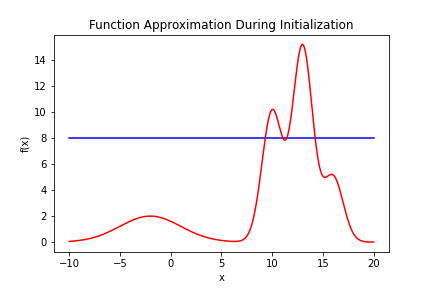

In [6]:
load_file = ''

# Load Existing ODA Model
if len(load_file)>0:

    with open(load_file+'.pkl', mode='rb') as file:
        clf = pickle.load(file)

    clf.load()

# Initialize ODA    
else:
    
    clf = ODA(train_data=train_data,train_labels=train_labels,regression=True,
              Tmin=Tmin,Kmax=Kmax,lvq=lvq,error_threshold = error_threshold)

print('*** ODA Model Initialized ***')
oPlot = FlowLayout()
for r in range(len(res)):
    xp = [[xo[i]] for i in range(len(xo))]
    xp = [[td[r] for r in res] for td in xp]
    yp = []
    for xxp in xp:
        yp.append(clf.predict(xxp,r))
    ax = plt.subplot(111, autoscale_on=True)
    plt.plot(xo,np.array(yp),'b')
    plt.plot(xo,yo,'r')
    plt.title('Function Approximation During Initialization')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.close()
    oPlot.add_plot(ax)
oPlot.PassHtmlToCell()

## Fit Model

In [7]:
print('*** ODA ***')

clf.fit(test_data=test_data,test_labels=test_labels)

print('*** ODA ***')
accuTrain = clf.score(train_data, train_labels)
accuTest = clf.score(test_data, test_labels)
print(f'Train Ave. Distortion: {accuTrain}') 
print(f'Test Ave. Distortion: {accuTest}')    
print(f'Running time: {np.sum(clf.myTime):.1f}s')

*** ODA ***
2 -- ID: [0]: Samples: 36(+36): T = 0.9000, K = 2, treeK = 2, [+1.0s]
Train Error: 8.2584
Test Error: 8.3426
3 -- ID: [0]: Samples: 193(+157): T = 0.0900, K = 4, treeK = 4, [+0.0s]
Train Error: 4.7729
Test Error: 4.7532
4 -- ID: [0]: Samples: 598(+405): T = 0.0450, K = 8, treeK = 8, [+0.1s]
Train Error: 1.5129
Test Error: 1.3093
5 -- ID: [0]: Samples: 812(+214): T = 0.0360, K = 16, treeK = 16, [+0.1s]
Train Error: 1.4911
Test Error: 1.6743
6 -- ID: [0]: Samples: 1073(+261): T = 0.0288, K = 31, treeK = 31, [+0.5s]
Train Error: 0.3515
Test Error: 0.2764
7 -- ID: [0]: Samples: 1303(+230): T = 0.0230, K = 53, treeK = 53, [+1.4s]
Train Error: 0.1398
Test Error: 0.1595
*** Idle Codevector Pruned ***
8 -- ID: [0]: Samples: 2009(+706): T = 0.0230, K = 53, treeK = 53, [+12.2s]
--- Maximum number of codevectors reached. 
ID: [0]: Trained
*** ODA ***
Train Ave. Distortion: 0.1397681632946605
Test Ave. Distortion: 0.15949005536798488
Running time: 15.4s


## Plot Training Curve


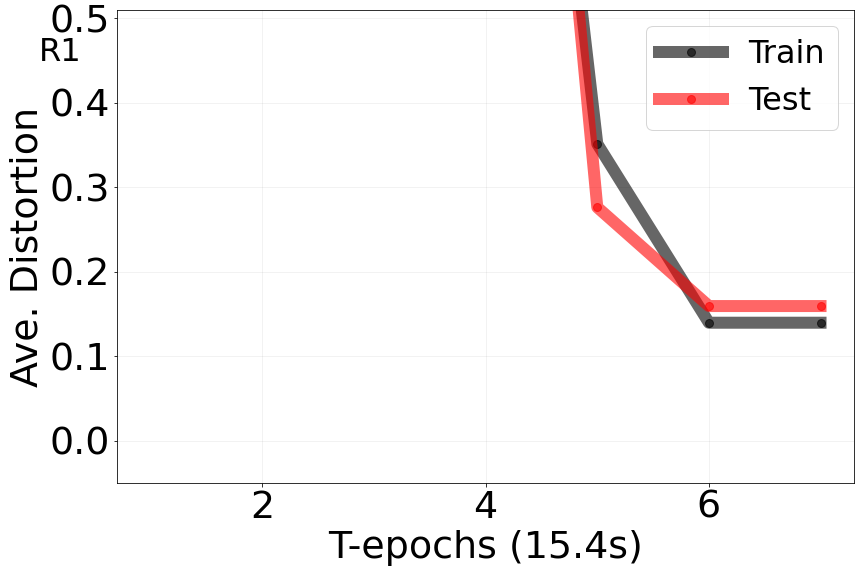

In [8]:
plot_curves = True

if clf.keepscore>1 and plot_curves:
    oPlot = FlowLayout()
    ax = clf.plot_curve('.', show = False, save = False)
    oPlot.add_plot(ax)
    oPlot.PassHtmlToCell()

## Show Domain

*** Plotting Domain ***



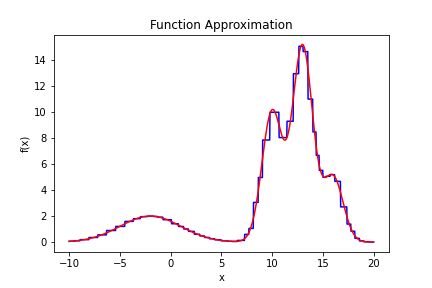

*** All Done ***


In [9]:
show_domain = True
res = [0]

if show_domain:
    print('*** Plotting Domain ***')
    oPlot = FlowLayout()
    for r in range(len(res)):
        xp = [[xo[i]] for i in range(len(xo))]
        xp = [[td[r] for r in res] for td in xp]
        yp = []
        for xxp in xp:
            yp.append(clf.predict(xxp,r))
        ax = plt.subplot(111, autoscale_on=True)
        plt.plot(xo,np.array(yp),'b')
        plt.plot(xo,yo,'r')
        plt.title('Function Approximation')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.close()
        oPlot.add_plot(ax)
    oPlot.PassHtmlToCell()
print('*** All Done ***')

# Takeaways:

## [1] Emphasis to areas with higher probability density
- Here we assume uniform underlying probability density which leads to uniform histogram estimation

## [2] Trade-off between Performance and Complexity
- No need to pre-define number of clusters $K$ 
- Especially useful in communication and compression applications and embedded CPS systems

## [3] Annealing helps avoid poor local minima

## [4] Online Approach
- Update approximation with each observation (no dataset stored)
- Needs less observations than batch algorithms 

## [5] General Dissimilarity Measures
- Beyond distance measures: works with any Bregman divergence (squared Euclidean distance, KL divergence, etc.)

## [6] Can we alleviate quadratic complexity $O(K^2)$? 
- See Tree-Structured Version below

## Advanced Parameters (Developer Mode)

### Temperature Schedule

In [10]:
# lambda max values in [0,1]. T = (1-lambda)/lambda
Tmax = [0.9]

# T' = gamma * T
gamma_steady = [0.8] 
# Initial updates can be set to reduce faster
gamma_schedule = [[0.1,0.5]]

### Regularization

In [11]:
# Perturb (dublicate) existing codevectors 
# Parameter delta = d_phi(mu, mu+'delta')/T: 
perturb_param = [1e-1]
# Threshold to find merged (effective) codevectors
# Parameter e_n = d_phi(mu, mu+'effective_neighborhood')/T
effective_neighborhood = [1e-0]
# Parameter e_r: threshold to find idle codevectors
py_cut = [1e-6]

### Convergence Parameters

In [12]:
# Parameter e_c =  d_phi(mu, mu+'em_convergence')/T
em_convergence = [1e-1]
# Convergece when d_phi(mu',mu) < e_c * (1+bb_init)/(1+bb) for 'convergence_counter_threshold' times
convergence_counter_threshold = [5]
# After 'stop_separation' loops, gibbs probabilities consider all codevectors regardless of class 
stop_separation = [1e6-1] 
# Custom number of loops until convergence is considered true (overwrites e_c) (Developer mode)
convergence_loops = [0]
# Initial bb value for stochastic approximation stepsize: 1/(bb+1)
bb_init = [0.9]
# bb+=bb_step
bb_step = [0.9]

### Verbose

In [13]:
# Values in {0,1,2,3}    
# 0: don't compute or show score
# 1: compute and show score only on tree node splits 
# 2: compute score after every SA convergence and use it as a stopping criterion
# 3: compute and show score after every SA convergence and use it as a stopping criterion
keepscore = 3

### Numba Jit

In [14]:
# Using jit/python for Bregman divergences
jit = True

# Tree-Structured ODA

## Data

In [15]:
# Tree Layers: Up to 3 layers
res=[0,0,0]

# Train data
xo = np.atleast_2d(np.linspace(-10, 20, 1000)).T
yo = f(xo).ravel()
shi = np.arange(len(xo))
np.random.shuffle(shi)
x = [[xo[i]] for i in shi]
y = [np.array([yo[i]]) for i in shi]
train_data=[xx for xx in x]
train_labels=[yy for yy in y]

# Test data
xoo = np.atleast_2d(np.linspace(-10, 20, 100)).T
yoo = f(xoo).ravel()
shi = np.arange(len(xoo))
np.random.shuffle(shi)
x = [[xoo[i]] for i in shi]
y = [np.array([yoo[i]]) for i in shi]
test_data=[xx for xx in x]
test_labels=[yy for yy in y]

# Resolutions
train_data = [[td[r] for r in res] for td in train_data]
test_data = [[td[r] for r in res] for td in test_data]

print(f'Training Data Format: [{train_data[0]}, ..., {train_data[-1]}]')
print(f'Training Labels Format: [{train_labels[0]}, ..., {train_labels[-1]}]')

Training Data Format: [[array([-9.24924925]), array([-9.24924925]), array([-9.24924925])], ..., [array([7.47747748]), array([7.47747748]), array([7.47747748])]]
Training Labels Format: [[0.10791764], ..., [0.4288213]]


## Growing Criteria

In [16]:
## Stop each layer after reaching predefined error
error_threshold = [0.0]
## Stop each layer at predefined number of children
Kmax = [10, 5, 2]
## Stop each layer at predefined temperature levels
Tmax = [0.9]
Tmin = [1e-3]
gamma_schedule = [[0.1,0.5]]

clf = ODA(train_data=train_data,train_labels=train_labels,regression=True,
          error_threshold=error_threshold,
         Kmax=Kmax,Tmax=Tmax,Tmin=Tmin,gamma_schedule=gamma_schedule)

print('*** Tree-Structured ODA Initialized***')
# demo_domain.data(clf=clf, res=[1], plot_fig=True,save_fig = False)

*** Tree-Structured ODA Initialized***


## Comments on Growing/Splitting Criteria

> These are predefined termination criteria.

> Most of them do not require feedback (error calculation with respect to some dataset).

> This is reminiscent of genetic algorithms.

> Adaptive termination criteria with respect to feedback (e.g., relative change to error) can also be implemented.

> For an application-specific extension please contact the author.

## Fit Tree-Structured ODA

In [17]:
print('*** ODA ***')

clf.fit(test_data=test_data,test_labels=test_labels)

print('*** ODA ***')
accuTrain = clf.score(train_data, train_labels)
accuTest = clf.score(test_data, test_labels)
print(f'Ave. Distortion: {accuTrain}') 
print(f'Ave. Distortion: {accuTest}')    
print(f'Running time: {np.sum(clf.myTime):.1f}s')

*** ODA ***
2 -- ID: [0]: Samples: 52(+52): T = 0.9000, K = 2, treeK = 2, [+0.0s]
Train Error: 10.4005
Test Error: 10.3780
3 -- ID: [0]: Samples: 241(+189): T = 0.0900, K = 4, treeK = 4, [+0.0s]
Train Error: 9.8399
Test Error: 9.9069
4 -- ID: [0]: Samples: 434(+193): T = 0.0450, K = 8, treeK = 8, [+0.0s]
Train Error: 3.4511
Test Error: 3.6647
5 -- ID: [0]: Samples: 652(+218): T = 0.0450, K = 8, treeK = 8, [+0.1s]
--- Maximum number of codevectors reached. 
ID: [0]: Trained. Splitting..
6 -- ID: [0, 7]: Samples: 13(+13): T = 0.9000, K = 2, treeK = 9, [+0.0s]
Train Error: 3.5792
Test Error: 3.7991
7 -- ID: [0, 0]: Samples: 12(+12): T = 0.9000, K = 2, treeK = 10, [+0.0s]
Train Error: 3.6552
Test Error: 3.8751
8 -- ID: [0, 3]: Samples: 17(+17): T = 0.9000, K = 2, treeK = 11, [+0.0s]
Train Error: 3.8675
Test Error: 4.0996
9 -- ID: [0, 2]: Samples: 10(+10): T = 0.9000, K = 1, treeK = 11, [+0.1s]
Train Error: 3.2750
Test Error: 3.4794
10 -- ID: [0, 4]: Samples: 17(+17): T = 0.9000, K = 2, tre

72 -- ID: [0, 0]: Samples: 259(+109): T = 0.0450, K = 4, treeK = 36, [+1.0s]
--- Maximum number of codevectors reached. 
ID: [0, 0]: Trained. Splitting..
73 -- ID: [0, 3, 2]: Samples: 38(+30): T = 0.0900, K = 1, treeK = 36, [+0.8s]
Train Error: 0.0882
Test Error: 0.0886
74 -- ID: [0, 2, 0]: Samples: 25(+18): T = 0.0900, K = 1, treeK = 36, [+0.7s]
Train Error: 0.0878
Test Error: 0.0882
75 -- ID: [0, 0, 0]: Samples: 6(+6): T = 0.9000, K = 1, treeK = 36, [+0.1s]
Train Error: 0.0877
Test Error: 0.0888
76 -- ID: [0, 7, 3]: Samples: 20(+11): T = 0.0900, K = 1, treeK = 36, [+0.5s]
Train Error: 0.0876
Test Error: 0.0887
77 -- ID: [0, 0, 1]: Samples: 7(+7): T = 0.9000, K = 1, treeK = 36, [+0.1s]
Train Error: 0.0883
Test Error: 0.0885
78 -- ID: [0, 5, 0]: Samples: 8(+8): T = 0.9000, K = 1, treeK = 36, [+0.6s]
Train Error: 0.0886
Test Error: 0.0889
79 -- ID: [0, 5, 2]: Samples: 6(+6): T = 0.9000, K = 1, treeK = 36, [+0.6s]
Train Error: 0.0886
Test Error: 0.0887
80 -- ID: [0, 2, 3]: Samples: 34(+2

141 -- ID: [0, 2, 0]: Samples: 96(+37): T = 0.0360, K = 2, treeK = 56, [+0.9s]
Train Error: 0.0317
Test Error: 0.0345
142 -- ID: [0, 1, 1]: Samples: 86(+31): T = 0.0360, K = 2, treeK = 56, [+0.8s]
Train Error: 0.0316
Test Error: 0.0344
143 -- ID: [0, 0, 3]: Samples: 54(+27): T = 0.0450, K = 1, treeK = 56, [+1.0s]
Train Error: 0.0317
Test Error: 0.0342
144 -- ID: [0, 7, 3]: Samples: 86(+35): T = 0.0360, K = 2, treeK = 56, [+0.9s]
Train Error: 0.0316
Test Error: 0.0341
145 -- ID: [0, 1, 0]: Samples: 101(+44): T = 0.0360, K = 2, treeK = 56, [+0.9s]
Train Error: 0.0316
Test Error: 0.0342
146 -- ID: [0, 3, 3]: Samples: 93(+31): T = 0.0360, K = 2, treeK = 57, [+0.8s]
Train Error: 0.0303
Test Error: 0.0322
147 -- ID: [0, 2, 3]: Samples: 108(+35): T = 0.0360, K = 2, treeK = 57, [+0.7s]
Train Error: 0.0301
Test Error: 0.0322
148 -- ID: [0, 3, 0]: Samples: 98(+30): T = 0.0360, K = 2, treeK = 58, [+0.8s]
Train Error: 0.0287
Test Error: 0.0309
149 -- ID: [0, 5, 1]: Samples: 87(+31): T = 0.0360, K 

211 -- ID: [0, 5, 3]: Samples: 163(+45): T = 0.0230, K = 2, treeK = 65, [+0.7s]
Train Error: 0.0223
Test Error: 0.0239
212 -- ID: [0, 0, 1]: Samples: 176(+53): T = 0.0230, K = 2, treeK = 65, [+0.8s]
Train Error: 0.0223
Test Error: 0.0238
213 -- ID: [0, 5, 2]: Samples: 180(+35): T = 0.0230, K = 2, treeK = 65, [+0.5s]
Train Error: 0.0223
Test Error: 0.0238
214 -- ID: [0, 7, 2]: Samples: 201(+57): T = 0.0230, K = 2, treeK = 65, [+0.9s]
Train Error: 0.0223
Test Error: 0.0238
215 -- ID: [0, 0, 2]: Samples: 139(+33): T = 0.0230, K = 2, treeK = 65, [+0.7s]
Train Error: 0.0223
Test Error: 0.0237
216 -- ID: [0, 0, 3]: Samples: 152(+39): T = 0.0230, K = 2, treeK = 65, [+0.7s]
Train Error: 0.0223
Test Error: 0.0237
217 -- ID: [0, 5, 0]: Samples: 150(+39): T = 0.0230, K = 2, treeK = 65, [+0.7s]
Train Error: 0.0222
Test Error: 0.0235
218 -- ID: [0, 1, 3]: Samples: 230(+60): T = 0.0288, K = 2, treeK = 65, [+0.7s]
--- Maximum number of codevectors reached. 
ID: [0, 1, 3]: Trained
219 -- ID: [0, 2, 2]

## Plot Training Curve


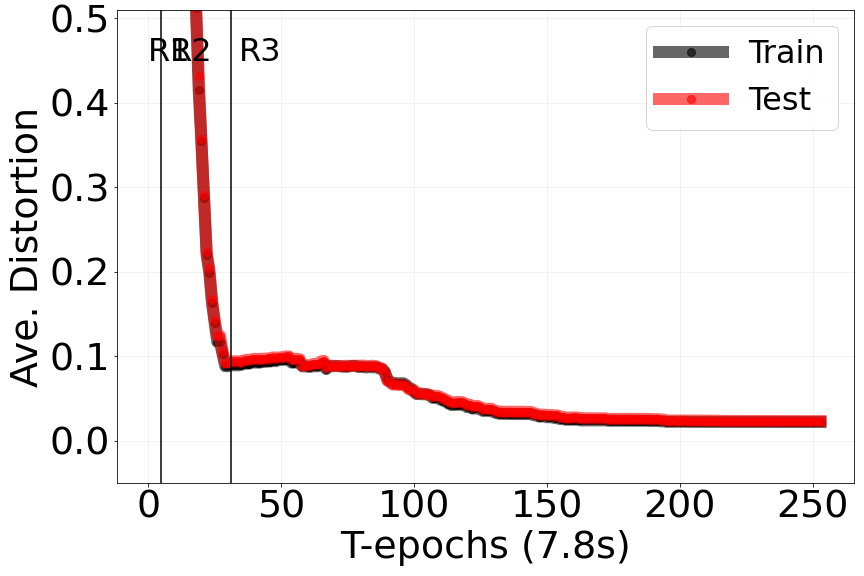

In [18]:
if clf.keepscore>1 and plot_curves:
    oPlot = FlowLayout()
    ax = clf.plot_curve('.', show = False, save = False)
    oPlot.add_plot(ax)
    oPlot.PassHtmlToCell()

## Show Domain

*** Plotting Domain ***



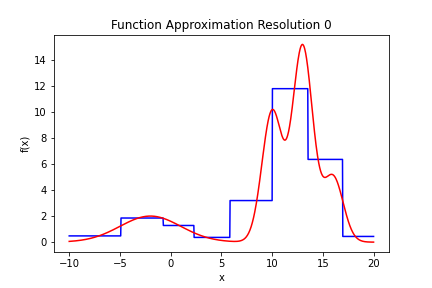
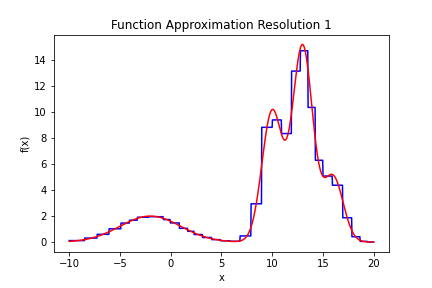
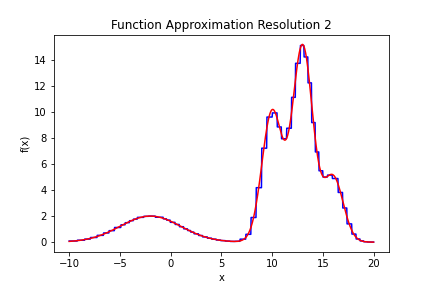

*** All Done ***


In [19]:
show_domain = True

if show_domain:
    print('*** Plotting Domain ***')
    oPlot = FlowLayout()
    for r in range(len(res)):
        xp = [[xo[i]] for i in range(len(xo))]
        xp = [[td[i] for i in res] for td in xp]
        yp = []
        for xxp in xp:
            yp.append(clf.predict(xxp,r))
        ax = plt.subplot(111, autoscale_on=True)
        plt.plot(xo,np.array(yp),'b')
        plt.plot(xo,yo,'r')
        plt.title(f'Function Approximation Resolution {r}')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.close()
        oPlot.add_plot(ax)
    oPlot.PassHtmlToCell()
print('*** All Done ***')

# Takeaways:

## [1] Reduction in time complexity $O(|C|^2 + |C| \log_{|C|} K) < O(K^2)$
- $|C|<<K$: number of children nodes 
- typically $|C|>2$, which implies $\log_{|C|} K<\log_{2} K$ ($|C|=2$ in binary trees)
- Compare running time and accuracy

## [2] Hierarchical Regression 
- Reduces prediction time to $O(|C| \log_{|C|} K) < O(K^2)$
- Creates hierarchical (multi-resolution) approximation of the original function useful in progressive learning, etc.